# Reactive transport of CO<sub>2</sub>-saturated brine along a porous rock column

In this tutorial, we show how Reaktoro can be used for one-dimensional reactive transport calculations for modeling
the geochemical reactions that occur along a porous rock column as an aqueous fluid is continuously injected on its
left side.

The injected fluid is a brine with 0.9 molal NaCl, 0.05 molal MgCl<sub>2</sub>, 0.01 molal CaCl<sub>2</sub>
and almost CO<sub>2</sub>-saturated, with 0.75 molal of CO<sub>2</sub> dissolved.
The porous rock is initially composed of minerals quartz SiO<sub>2</sub> and calcite CaCO<sub>3</sub>. The
initial porosity is 10 %, and the initial volume percentages of the minerals are 98 %<sub>vol</sub> of quartz and
2 %<sub>vol</sub> calcite. The initial conditions for the fluid in the rock is a 0.7 molal NaCl brine in
equilibrium with the existing rock minerals calcite and quartz. These initial fluid and rock composition conditions
are uniform throughout the rock core. We assume a rock column length of 100 m at temperature 60 &deg;C and 100 bar
throughout.

**Assumptions**: To simplify this tutorial, the following assumptions are made:
* Chemical equilibrium is used for modeling the chemical reactions in this problem, not only for reactions between
aqueous-aqueous species but also for those between mineral and aqueous species.
* A uniform constant velocity field is imposed and it is not updated by solving, for example, Darcy equation.
* Both temperature and pressure are also kept constant along the rock.

## Import the reaktoro Python package (and other packages)
First, we import the **reaktoro** Python package so that we can use its classes
and methods for performing the chemical reaction calculations.

In [1]:
from reaktoro import *
import numpy as np
import os
import matplotlib.pyplot as plt
from natsort import natsorted

We import the **reaktoro** Python package so that we can use its classes and methods for performing chemical
reaction calculations, **numpy** for working with arrays, **os** to provide a portable way of using operating system
dependent functionality, **matplotlib** for plotting capabilities, and *natsort* for sorting lists.

## Defining auxiliary time-related constants
In this step, we initialize auxiliary time-related constants from seconds to years. This is only done for
convenience, so that we can specify later, for example, fluid velocity as 1 m/week.

In [2]:
second = 1
minute = 60
hour = 60 * minute
day = 24 * hour
week = 7 * day
year = 365 * day

## Defining parameters for the reactive transport simulation
Next, we define reactive transport and numerical discretization parameters. In particular, we specify the considered
rock domain by setting coordinates of its left and right boundaries to 0.0 m and 100.0 m, respectively. The
discretization parameters, i.e., the number of cells and steps in time, are both set to 100. The reactive
transport modeling procedure assumes a constant fluid velocity of 1 m/week (1.16 · $10^{-5}$ m/s) and the same
diffusion coefficient of $10^{-9}$ m<sup>2</sup>/s for all fluid species (without dispersivity). The size of the
time-step is set to 30 minutes. Temperature and pressure are set to 60 &deg;C and 100 bar, respectively,
throughout the whole tutorial.

Discretisation parameters

In [ ]:
xl = 0.0                # the x-coordinate of the left boundary
xr = 1.0                # the x-coordinate of the right boundary
ncells = 100            # the number of cells in the discretization
nsteps = 300             # the number of steps in the reactive transport simulation
dt = 30*minute          # the time step (30 minutes in units of s)
dx = (xr - xl)/ncells   # length of the mesh cells (in units of m)

Physical parameters

In [4]:
D  = 1.0e-9             # the diffusion coefficient (in units of m2/s)
v  = 1.0/week           # the fluid pore velocity (1 m/week in units of m/s)
T = 60.0                # the temperature (in units of degC)
P = 100                 # the pressure (in units of bar)
phi = 0.1               # the porosity

Next, we generate the coordinates of the mesh nodes (array `x`) by equally dividing the interval *[xr, xl]* with
the number of cells `ncells`. The length between each consecutive mesh nodes is computed and stored in `dx` (the
length of the mesh cells).

In [5]:
xcells = np.linspace(xl, xr, ncells)    # interval [xl, xr] split into ncells

To make sure that the applied finite-volume scheme is stable, we need to keep track of Courant–Friedrichs–Lewy (CFL)
number, which should be less than 1.0.

In [6]:
CFL = v*dt/dx
print(f"Make sure that CFL = {v*dt/dx} is less that 1.0")

Make sure that CFL = 0.2976190476190476 is less that 1.0


Another auxiliary parameter is the number of digits in the number of steps (e.g., 100 has 3 digits). It is needed for
generation of the names of the files, where chemical states are saved, as well as the creating of the videos.

In [7]:
ndigits = len(str(nsteps))

Output folder name:

In [8]:
folder_results = 'results'
folder_videos  = 'videos'

## Auxiliary functions

Below, we list auxiliary function used in the python tutorial. Function `titlestr` returns a string for the title of
a figure in the format `Time: _h__m`, e.g., `Time:1h35m`.

In [9]:
def titlestr(t):
    t = t / minute   # Convert from seconds to minutes
    h = int(t) / 60  # The number of hours
    m = int(t) % 60  # The number of remaining minutes
    return 'Time: {:>3}h{:>2}m'.format(h, str(m).zfill(2))

Using **os** package, we create required folders for outputting the obtained results and for the plot and video
files later.

In [10]:
def make_results_folders():
    os.system('mkdir -p ' + folder_results)
    os.system('mkdir -p ' + folder_videos)

## Reactive transport simulations

### Defining the chemical system

We need to define a chemical system that can represent both our fluid and rock. We use class
[ChemicalEditor](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalEditor.html) below to define a system with an
aqueous phase and three mineral phases: quartz, calcite, and dolomite. Initially, our rock has no dolomite
(CaMg(CO<sub>3</sub>)<sub>2</sub>), but since this is a mineral that could potentially precipitate given the fluid
composition injected ( containing CaCl<sub>2</sub> and MgCl<sub>2</sub> dissolved), we add it here in the
chemical system to ensure that the calculations are able to model dolomite precipitation.

In [11]:
db = Database('supcrt98.xml')
editor = ChemicalEditor(db)
editor.addAqueousPhase('H2O(l) H+ OH- Na+ Cl- Ca++ Mg++ HCO3- CO2(aq) CO3--')
editor.addMineralPhase('Quartz')
editor.addMineralPhase('Calcite')
editor.addMineralPhase('Dolomite')

> **Note**: The aqueous phase is defined above by using a list of compounds, which is then broken automatically by
> Reaktoro into a list of element names. These element names are then used to find in the database all the aqueous
> species that could be formed out of them.

### Constructing the chemical system

This step is where we create an object of class
[ChemicalSystem](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalSystem.html) using the
chemical system definition details stored in the object ``editor``.

In [12]:
system = ChemicalSystem(editor)

### Initial condition for the fluid composition

Below, we define the **initial condition** for the fluid composition in the rock. We want an aqueous fluid that is
0.7 molal of NaCl and in equilibrium with calcite and quartz. To achieve this, we mix 1 kg of water, 0.7 mol of
NaCl, and plenty of calcite and quartz (10 mol each) to ensure that the aqueous solution is saturated with respect
to these minerals.

In [13]:
problem_ic = EquilibriumProblem(system)
problem_ic.setTemperature(T, 'celsius')
problem_ic.setPressure(P, 'bar')
problem_ic.add('H2O', 1.0, 'kg')
problem_ic.add('NaCl', 0.7, 'mol')
problem_ic.add('CaCO3', 10, 'mol')
problem_ic.add('SiO2', 10, 'mol')

### Boundary condition for the fluid composition

Next, we define the **boundary condition** for the fluid composition on the left side of the rock, which should be
the one that represents the fluid being continuously injected: 0.9 molal NaCl, 0.05 molal MgCl<sub>2</sub>,
0.01 molal CaCl<sub>2</sub> and almost CO<sub>2</sub>-saturated, with 0.75 molal of CO<sub>2</sub> dissolved. To
provide that, we mix 1 kg of HO<sub>2</sub> with 0.9 mol of NaCl, 0.05 mol of MgCl<sub>2</sub>, 0.01 mol
of CaCl<sub>2</sub>, and 0.75 mol of CO<sub>2</sub>.

In [14]:
problem_bc = EquilibriumProblem(system)
problem_bc.setTemperature(T, 'celsius')
problem_bc.setPressure(P, 'bar')
problem_bc.add('H2O', 1.0, 'kg')
problem_bc.add('NaCl', 0.90, 'mol')
problem_bc.add('MgCl2', 0.05, 'mol')
problem_bc.add('CaCl2', 0.01, 'mol')
problem_bc.add('CO2', 0.75, 'mol')

### Calculating the IC and BC fluid compositions
In this step, we use the [equilibrate](https://reaktoro.org/cpp/namespaceReaktoro.html#af2d3b39d3e0b8f9cb5a4d9bbb06b697e)
function to calculate the chemical equilibrium state of the system with the given initial and boundary equilibrium
conditions stored in the object `problem_ic` and `problem_bc`, respectively. The result is stored in the
corresponding instances of the class [ChemicalState](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalState.html),
i.e., `state_ic` and `state_bc`.

In [15]:
state_ic = equilibrate(problem_ic)
state_bc = equilibrate(problem_bc)

### Scaling the phases in the initial condition

The initial chemical state `state_ic` computed before has, at this point, phases with volumes that do not
correspond to our desired porosity of 10 % and rock mineral composition of 98 %<sub>vol</sub> of quartz and
2 %<sub>vol</sub> of calcite.

To obtain this, we scale the volumes of the aqueous and mineral phases as shown
below:

In [16]:
# Scale the volumes of the phases in the initial condition
state_ic.scalePhaseVolume('Aqueous', 0.1, 'm3') # corresponds to the initial porosity of 10%.
state_ic.scalePhaseVolume('Quartz', 0.882, 'm3')
state_ic.scalePhaseVolume('Calcite', 0.018, 'm3')

> **Note**: After this scaling step, the sum of the phase volumes in ``state_ic`` is 1 m<sup>3</sup>. This also
> ensures that the amounts of the species in the chemical system are normalized by m<sup>3</sup>, and thus they can
> be regarded as concentrations in a unit of mol/m<sup>3</sup> (*bulk volume, not fluid volume!*).

### Scaling the boundary condition state

Next, we scale the boundary condition state to 1 m<sup>3</sup>, so that we have the amounts of fluid species in
`state_bc` also normalized by m<sup>3</sup>.

> **Note**: The chemical state represented by `state_bc` has no other stable phase than the aqueous phase (i.e.,
> all mineral phases have zero or negligible amounts such as $10^{-21}$ mol).

In [17]:
state_bc.scaleVolume(1.0, 'm3')

### Creating the mesh

We define the mesh with the class [Mesh](https://reaktoro.org/cpp/classReaktoro_1_1Mesh.html) to use in
the initialization of class [ReactiveTransportSolver](
https://reaktoro.org/cpp/classReaktoro_1_1ReactiveTransportSolver.html) later. Here, we specify the number of cells
in the mesh and the x-coordinates of the left and right boundaries (in m).

In [18]:
mesh = Mesh(ncells, xl, xr)

### Creating a chemical field object

We have been using class [ChemicalState](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalState.html) to represent
an individual chemical state. We will now use class [ChemicalField](
https://reaktoro.org/cpp/classReaktoro_1_1ChemicalField.html) to represent a collection of chemical states: one for
each mesh cell.

> **Note**: Different initial conditions across the mesh cells are possible by assigning different chemical states to
> each mesh cell. Here, the same chemical state in `state_ic` is used for all cells.

In [19]:
field = ChemicalField(mesh.numCells(), state_ic)

### Initializing the reactive transport solver

At last, we define the object responsible for solving the reactive transport problem, which is handled by the
class [ReactiveTransportSolver](https://reaktoro.org/cpp/classReaktoro_1_1ReactiveTransportSolver.html).
Here, we set the mesh and problem parameters such as velocity, diffusion coefficient, the chemical state
representing the boundary condition, and the time step. We also initialize the reactive solver object with the
chemical field object specified on the previous step, at this point containing the initial condition for the
chemical state of each mesh cell.

In [20]:
rt = ReactiveTransportSolver(system)
rt.setMesh(mesh)
rt.setVelocity(v)
rt.setDiffusionCoeff(D)
rt.setBoundaryState(state_bc)
rt.setTimeStep(dt)
rt.initialize(field)

### Defining the output quantities

Before starting the reactive transport calculations, we define the quantities that will be output for every mesh
cell, at every time step. For this, we use an object of the class
[ChemicalOutput](https://reaktoro.org/cpp/classReaktoro_1_1ChemicalOutput.html).
The name of the output file is to `reactive-transport.txt`. We specify the parameters that we are interested in
outputting. In this case, it is pH, molality of `H+`, `Ca++`, `Mg++`, `HCO3-`, `CO2(aq)`, as well as a phase volume
of calcite and dolomite.

In [21]:
output = rt.output()
output.add("pH")
output.add("speciesMolality(H+)")
output.add("speciesMolality(Ca++)")
output.add("speciesMolality(Mg++)")
output.add("speciesMolality(HCO3-)")
output.add("speciesMolality(CO2(aq))")
output.add("phaseVolume(Calcite)")
output.add("phaseVolume(Dolomite)")
output.filename(folder_results + '/state.txt')  # Set the name of the output files

In [22]:
# Make auxiliary folders to save generated results, their plots, or videos
make_results_folders()

### Running the reactive transport simulation

As shown below, we perform a sequence of reactive transport calculations, one for each time step, during which the
chemical state of each mesh cell is updated. The iterations continue until the maximum number of steps is
achieved.

Using **tqdm** we track the progress of simulations using the progress bar. For that, we wrap the while-loop with
the function 'tqdm()'. We then use the method `step` of class
[ReactiveTransportSolver](https://reaktoro.org/cpp/classReaktoro_1_1ReactiveTransportSolver.html) to perform a
single  reactive transport time-stepping. This method also produces a new output file containing the requested
output properties for every mesh cell. In each such file, rows correspond to cells, whereas the columns correspond
to the requested output properties, i.e., pH, molality of `H+`, `Ca++`, `Mg++`, `HCO3-`, `CO2(aq)`, as
well as the phase volume of calcite and dolomite.

In [23]:
# Step 15: Perform given number of reactive tranport steps
t = 0.0  # current time variable
step = 0  # current number of steps

from tqdm.notebook import tqdm
with tqdm(total=nsteps, desc="Reactive transport simulations") as pbar:
    while step <= nsteps:  # step until the number of steps are achieved

        # Perform one reactive transport time step
        rt.step(field)

        # Increment time step and number of time steps
        t += dt
        step += 1

        pbar.update(1)

## Plotting of the obtained results
The last block of the main routine is dedicated to plotting of the results and generating a video from the plots to
illustrate the time-dependent behavior of the chemical properties. It uses parallel pthread to run `plotfile`
function for each file from the list `files`.

First, we collect files with results using `listdir` function, which returns the list containing the names of
the entries in the directory given by path `folder_results`:

In [24]:
files = [file for file in natsorted( os.listdir(folder_results) ) ]

To generate animations, we exploit **animation** module of the library **matplotlib**, which provides the framework
to build videos from the plots. **Note:**: **ffmpeg** must be installed for handling video, audio, and other
multimedia files and streams.

In [34]:
from matplotlib import animation
from IPython.display import Video

animation_starts_at_frame = 0      # the first frame index to be considered
animation_ends_at_frame = 10 * 30  # the last frame index to be considered
animation_num_frames_to_jump = 1     # the number of frames to jump between current and next
# Check for the correct end frame number
assert animation_ends_at_frame <= nsteps, "WARNING: The number of the end frame must be smaller then number of steps! " 

Provide the number of frames per second and the time (in milliseconds) to wait between each frame:

In [35]:
animation_fps = 30 # the number of frames per second
animation_interval_wait = 200    # the time (in milliseconds) to wait between each frame

In [36]:
# Auxiliary animation options
animation_frame_range = range(animation_starts_at_frame, animation_ends_at_frame, animation_num_frames_to_jump)

For plotting of the data saved under the `folder_results` folder, we provide the indices corresponding to the columns
written to the `state.txt` files.

In [37]:
indx_ph        = 0
indx_Hcation   = 1
indx_Cacation  = 2
indx_Mgcation  = 3
indx_HCO3anion = 4
indx_CO2aq     = 5
indx_calcite   = 6
indx_dolomite  = 7

Routines `plot_animation_ph()`, `plot_animation_calcite_dolomite()`, and 'plot_animation_aqueous_species()'
are dedicated to animating the time-dependent behavior of the chemical properties.

In [38]:
def line(color):
    return {'linestyle': '-', 'color': color, 'zorder': 1, 'linewidth': 2}

def plot_animation_ph():

    # Plot of mineral's volume the space coordinates
    fig = plt.figure()
    ax = plt.axes(xlim=(-0.01, 0.501), ylim=(2.5, 12.0))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('pH')
    ax.set_title(titlestr(0.0))
    objects = [
        ax.plot([], [], label='pH', **line('teal'))[0],
    ]
    ax.legend(loc='lower right')

    def init():
        return tuple(objects)

    def animate(i):
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i], skiprows=1)
        data = filearray.T
        data_ph = data[indx_ph]
        objects[0].set_data(xcells, data_ph)
        ax.set_title(titlestr(t))
        return tuple(objects)

    print("Generating the animation of pH behaviour ...")
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=animation_frame_range, interval=animation_interval_wait, blit=True)
    anim.save(folder_videos + '/pH.mp4', fps=animation_fps, extra_args=['-vcodec', 'libx264'])
    print("Finished!")

def plot_animation_calcite_dolomite():

    # Plot of mineral's volume the space coordinates
    fig = plt.figure()
    ax = plt.axes(xlim=(-0.01, 0.501), ylim=(-0.1, 2.1))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Mineral Volume [%$_{\mathsf{vol}}$]')
    ax.set_title(titlestr(0.0))
    objects = [
        ax.plot([], [], label='Calcite', **line('C0'))[0],
        ax.plot([], [], label='Dolomite', **line('C1'))[0],
    ]
    ax.legend(loc='center right')


    def init():
        return tuple(objects)


    def animate(i):
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i], skiprows=1)
        data = filearray.T
        data_calcite, data_dolomite = data[indx_calcite], data[indx_dolomite]
        objects[0].set_data(xcells, data_calcite * 100/(1 - phi))
        objects[1].set_data(xcells, data_dolomite * 100/(1 - phi))
        ax.set_title(titlestr(t))
        return tuple(objects)

    print("Generating the animation of calcite-dolomite behaviour ...")
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=animation_frame_range, interval=animation_interval_wait, blit=True)
    anim.save(folder_videos + '/calcite-dolomite.mp4', fps=animation_fps, extra_args=['-vcodec', 'libx264'])
    print("Finished!")

def plot_animation_aqueous_species():

    # Plot of mineral's volume the space coordinates
    fig = plt.figure()
    ax = plt.axes(xlim=(-0.01, 0.501), ylim=(0.5e-5, 2))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Concentration [molal]')
    ax.set_yscale('log')
    ax.set_title(titlestr(0.0))
    objects = [
        ax.plot([], [], label=r'$\mathrm{Ca^{2+}}$', **line('C0'))[0],
        ax.plot([], [], label=r'$\mathrm{Mg^{2+}}$', **line('C1'))[0],
        ax.plot([], [], label=r'$\mathrm{HCO_3^{-}}$',**line('C2'))[0],
        ax.plot([], [], label=r'$\mathrm{CO_2(aq)}$',**line('red'))[0],
        ax.plot([], [], label=r'$\mathrm{H^+}$', **line('darkviolet'))[0],
    ]
    ax.legend(loc='upper right')

    def init():
        return tuple(objects)

    def animate(i):
        t = i * dt
        filearray = np.loadtxt(folder_results + '/' + files[i], skiprows=1)
        data = filearray.T

        data_cacation  = data[indx_Cacation]
        data_mgcation  = data[indx_Mgcation]
        data_hco3anion = data[indx_HCO3anion]
        data_co2aq     = data[indx_CO2aq]
        data_hcation   = data[indx_Hcation]

        objects[0].set_data(xcells, data_cacation)
        objects[1].set_data(xcells, data_mgcation)
        objects[2].set_data(xcells, data_hco3anion)
        objects[3].set_data(xcells, data_co2aq)
        objects[4].set_data(xcells, data_hcation)
        ax.set_title(titlestr(t))
        return tuple(objects)

    print("Generating the animation of aqueous species behaviour ...")
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=animation_frame_range, interval=animation_interval_wait, blit=True)
    anim.save(folder_videos + '/aqueous-species.mp4', fps=animation_fps, extra_args=['-vcodec', 'libx264'])
    print("Finished!")

Generate animation with the ph behaviour:

Generating the animation of pH behaviour ...
Finished!


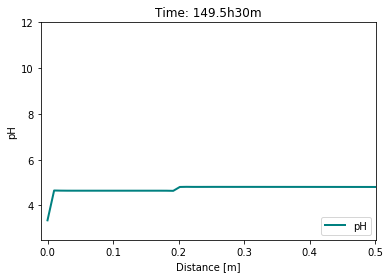

In [39]:
plot_animation_ph()

Show the resulting video:

In [40]:
Video(folder_videos + '/pH.mp4')

Generate animation with calcite and dolomite dynamics:

Generating the animation of calcite-dolomite behaviour ...
Finished!


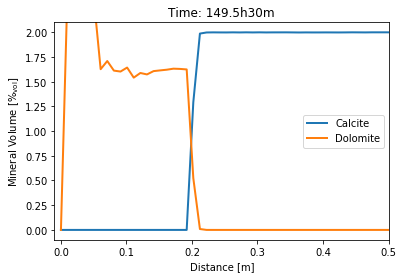

In [41]:
plot_animation_calcite_dolomite()

Show the video with precipitating dolomite and dissolving calcite:

In [42]:
Video(folder_videos + '/calcite-dolomite.mp4')

Generate an animation with aqueous species:

In [ ]:
plot_animation_aqueous_species()

Generating the animation of aqueous species behaviour ...


Show correcponding video:

In [ ]:
Video(folder_videos + '/aqueous-species.mp4')